<a name="intro"></a>
# Counting Syntax

Except where it was easier to perform similar analyses together, this sequence largely tracks the order of statistics and analyses in the manuscript. Analyses and figures are kept separate, however. Linear models can be found in the accompanying R file

<a name="top"></a>
## Contents

1. [Import Packages](#import)
2. [Retrieve Data from Mongo](#mongo)
3. [Make Exclusions](#exclude)
4. [Define Helper Functions](#functions)


5. [Add Derived Columns](#new_cols)  
    5.0 [Rename Columns](#rename)  
    5.1 [Re-Format Generalization Trials](#genDF)  
    5.2 [Retype Columns](#astype)  
    5.3 [Parse Rules of Composition](#rules)  
    5.4 [Cut up Data & Save to CSV](#saveout)
    
 
6. [Summary Statistics](#summaries)


7. [Figures](#figures)      
    7.1. [Figure 2](#fig2)  
    7.2. [Figure 3](#fig3)  
    7.3. [Figure 4](#fig4)  
   
   
8. [Simpsons Diversity Measure](#simpsons)

# <a name="import"></a> 1. Import Packages ([top](#top))

In [1]:
import os, sys
import pymongo as pm
import socket

import numpy as np
import scipy.stats as stats
import math
import pandas as pd
import json
import re
from io import BytesIO
import ast  # for interpreting strings as dictionary objects
import itertools

import matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.patches as mpatches
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
from matplotlib import rcParams
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['pdf.fonttype'] = 42

from IPython.display import clear_output
import importlib
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
pd.set_option("display.max_rows", None, "display.max_columns", None)
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


In [2]:
d = .5 # how dispersed should the scatter dots be? Depends on width of bars
fs = 12 # fontsize for text in the figure
lw = 1.5 # linewidth for the errorbars
cs = 0 # capsize for the errorbars
ew = 0 # edgewidth for the errorbars
ms = 5 # markerwidth for scatterplots
% matplotlib inline

# <a name="mongo"></a> 2. Retrieve Data from Mongo ([top](#top))

In [3]:
# set up connection to lab server
! ssh -fNL 27020:127.0.0.1:27017 sholt@cogtoolslab.org

# set vars
auth = pd.read_csv(os.path.join(os.getcwd(),'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017')
db = conn['num_syn']
coll_1 = db['proof_of_concept'] # Experiment 1 data is here
coll_2 = db['exp3']             # Experiment 2 data is here

# Now connect to mongo and fetch the data we want, which we will store as a dataframe

# Experiments 1a ('run1') and 1b ('run2'); 'repair1' is because of a snafu with base-3, 'cogsci2023' is additional N for Exp1 collected on the suggestion of a conference reviewer
iterationNames = ['run1' , 'run2' , 'repair1','cogsci2023']
print("Looking through mongo db for Exp1...")
clear_output(wait=True)
w1 = coll_1.find({'iterationName':{'$in': iterationNames}})
W1 = pd.DataFrame(w1)

# get rid of the faulty base-3 condition from the first run, where the number '9' was not formed correctly
W1 = W1.drop(W1[(W1['base'] == 3) & (W1['iterationName'] == 'run1')].index)

# Now Experiment 2
iterationName = 'run1'
print("Looking through mongo db for Exp2...")
clear_output(wait=True)
w2 = coll_2.find({'iterationName':iterationName})    
W2 = pd.DataFrame(w2)

W1 = W1.astype({'correct':'float'})
W2 = W2.astype({'correct':'float'})
W1['expt'] = 1
W2['expt'] = 2

# make the two dataframes compatible with each other (there were a couple differences in format), and append them
W1 = W1.rename(columns={'writingTime':'WT'})
W2 = W2.astype({'totalScore':'float'})
W2['totalScore'] = W2['totalScore'] / 100
W = W1.append(W2,ignore_index=True)

# label each game with some important features (all of Experiment 1 has both features):
W['syntax'] = W['condition'].apply(lambda x: x != 'no_syntax')
W['count']  = W['condition'].apply(lambda x: x != 'no_count' )

# Let's quickly save out a dataframe of all our raw data
Wraw = W

# anonymize the participant IDs
codenames = dict(zip(Wraw['prolificID'].unique(),np.arange(1,len(Wraw['prolificID'].unique())+1)))
Wraw['prolificID'] = Wraw['prolificID'].apply(lambda x: codenames[x])

Wraw.to_csv("../data/Wraw.csv")

print("Done")

Done


# <a name="exclude"></a> 3. Make Exclusions ([top](#top))

In [4]:

print("\033[1mExperiment 1\033[0m (Pre-Exclusions)")
print("\033[1m    Base              No Generalization  With Generalization\033[0m")
for base in W1.groupby(['base'])['gameID'].unique().index:
    indent1 = ' ' * (12-len(str(base)))
    with_gen = len(W1.groupby(['base'])['gameID'].unique()[base])
    indent2 = ' ' * (12-len(str(with_gen)))
    no_gen   = len(W1.loc[W1['eventType'] == 'generalization'].groupby(['base'])['gameID'].unique()[base])
    print("    Base {}:{}{} games{} {} games".format(base, indent1, with_gen, indent2, no_gen))
total = len(W1[W1['eventType'] == 'quiz'].gameID.unique())
gnrls = len(W1[W1['eventType'] == 'generalization'].gameID.unique()) # N.b. there is only one 'trial' in generalization
print("-"*60)
print("    Total:            {} games{}{} games".format(total,' ' * (13-len(str(total))),gnrls))
print()
print("="*60)

print("\033[1mExperiment 2\033[0m (Pre-Exclusions)")
print("\033[1m    Condition         No Generalization  With Generalization\033[0m")
for cond in W2.groupby(['condition'])['gameID'].unique().index:
    indent1 = ' ' * (12-len(str(cond)))
    with_gen = len(W2.groupby(['condition'])['gameID'].unique()[cond])
    indent2 = ' ' * (12-len(str(with_gen)))
    no_gen   = len(W2.loc[W2['eventType'] == 'generalization'].groupby(['condition'])['gameID'].unique()[cond])
    print("    {}:     {}{} games{} {} games".format(cond, indent1, with_gen, indent2, no_gen))
total = len(W2[W2['eventType'] == 'quiz'].gameID.unique())
gnrls = len(W2[W2['eventType'] == 'generalization'].gameID.unique()) # N.b. there is only one 'trial' in generalization
print("-"*60)
print("    Total:            {} games{}{} games".format(total,' ' * (13-len(str(total))),gnrls))

Experiment 1 (Pre-Exclusions)
    Base              No Generalization  With Generalization
    Base 2:           38 games           36 games
    Base 3:           49 games           44 games
    Base 4:           43 games           40 games
    Base 5:           54 games           41 games
    Base 8:           39 games           36 games
    Base 10:          44 games           38 games
------------------------------------------------------------
    Total:            267 games          235 games

Experiment 2 (Pre-Exclusions)
    Condition         No Generalization  With Generalization
    control:          43 games           39 games
    no_count:         42 games           38 games
    no_syntax:        48 games           42 games
------------------------------------------------------------
    Total:            131 games          119 games


In [5]:
# Exclusion criteria

# Before pre-registered criteria, find those people who took the experiment multiple times
temp = pd.DataFrame(W.groupby(["prolificID"])['gameID'].unique())       # see how many unique gameIDs per participant
temp = temp[temp['gameID'].apply(lambda x: len(x) > 1)]                 # filter to participants with multiple gameIDs

# now mark any game past their first one, because they are no longer naive to the task:
duplicates = []                                                         # create a list to hold non-naive game ids
temp['gameID'].apply(lambda x: duplicates.append(list(x)))              # add list of ALL games to duplicates
duplicates = [item for sublist in duplicates for item in sublist]       # flatten that list of list

# now find out which of the duplicate games came first, the others therefore being non-naive
temp = W.loc[W['gameID'].isin(duplicates)
            ].groupby(["prolificID"]).apply(lambda x: pd.DataFrame({'duplicate':x["initTime"].min() != x.groupby(["gameID"])["initTime"].min()}) )
duplicates = list(temp.loc[temp['duplicate']].reset_index()['gameID'])
W['duplicate'] = W['gameID'].isin(duplicates)                           # tag all those gameIDs identified as duplicates



# Accuracy: relevant to 2 criteria. Make a temporary datastructure to use for exclusions based on game accuracy (only look at people's first try)
gameAccs = W.loc[W['eventType'] == 'quiz'].loc[W['take']==0].groupby('gameID')[['correct']].mean()
gameAccs1 = W1.loc[W1['eventType'] == 'quiz'].loc[W1['take']==0].groupby('gameID')[['correct']].mean()
gameAccs2 = W2.loc[W2['eventType'] == 'quiz'].loc[W2['take']==0].groupby('gameID')[['correct']].mean()

# 17.1. Participants who had an accuracy on quiz trials of under 50% indicating unusual inattention to the task.
failedGames = gameAccs[gameAccs['correct'] < .5].index     # cutoff at 50%
W['failedGame'] = W['gameID'].isin(failedGames)            # set up tag for exclusion

# 17.2. Participants who write characters that are not part of the artificial number system in at least 3 trials.
##### First, for each game, find all the characters that belong in the count list
gameChars = W[W['eventType'] == 'quiz'].groupby(
    ['gameID'])[['target']].agg({"target":lambda x: x.str.cat()}).applymap(lambda x:set(x).union(set(x.upper()).union(set(' '))))
##### Second, make it a searchable dictionary ({gameID : character_set})
gameCharDict = pd.Series(gameChars.target.values,index=gameChars.index).to_dict()
##### Third, record every character used by each participant, in a new dataframe ("[W['eventType'] == 'quiz']", because one person only did a tutorial trial)
responseChars = W.loc[W['eventType'] == 'quiz'].groupby(['gameID','trialNum'])[['response']].agg(
    {"response":lambda x: x.str.cat()}).applymap(lambda x: set(x)).reset_index()                  # store user-generated characters in a set
responseChars['gameChars'] = responseChars[['gameID']].applymap(lambda x: gameCharDict[x])        # add the target character set
responseChars['intersection'] = responseChars['response'] - responseChars['gameChars']            # what's in the user set, but not target set?
responseChars['intersection'] = responseChars[['intersection']].applymap(lambda x: bool(len(x)))  # is anything in user set & not target set?
nonsenseFreq = responseChars.groupby('gameID')[['intersection']].sum() > 3                        # if there was an odd char in >3 trials
nonsenseGames = nonsenseFreq[nonsenseFreq['intersection'] == True].index                          # for such games, note them down
W['nonsenseGame'] = W['gameID'].isin(nonsenseGames)                                               # set up tag for exclusion

# 17.3. Participants who score less than 3 standard deviations below the mean score.
cutoff1 = float(gameAccs1.mean() - np.std(gameAccs1)*3)                         # get cutoff of 3sd around mean
gameAccs1 = gameAccs1[gameAccs1['correct'] < cutoff1].index                     # get those gameIDs that had lower scores
cutoff2 = float(gameAccs2.mean() - np.std(gameAccs2)*3)                         # get cutoff of 3sd around mean
gameAccs2 = gameAccs2[gameAccs2['correct'] < cutoff2].index                     # get those gameIDs that had lower scores
W['failedOutlier'] = W['gameID'].isin(gameAccs1) | W['gameID'].isin(gameAccs2)  # set up tag for exclusion


# 17.4. Participants who exit the experiment browser tab during more than five trials.
W['distracted'] = W[['distractions']].applymap(lambda x: 'blurred' in x.values())                               # when people left the screen
distractedTrials = W.groupby(['gameID','trialNum'])[['distracted']].agg({'distracted':lambda x: bool(sum(x))})  # identify distracted trials
distractedTrialFreq = distractedTrials.groupby(['gameID'])[['distracted']].sum().sort_values('distracted')      # distracted trials per game?
distractedTrialGames = distractedTrialFreq[distractedTrialFreq['distracted'] > 6].index                         # set the cutoff point
W['distractedGame'] = W['gameID'].isin(distractedTrialGames)                                                    # set up tag for exclusion

# 17.5. Participants who have to be excluded from payment on Prolific due to any of the platform’s exclusion criteria.
manual_exclusions = ['63cda4336ea406b65498774f',  # browser auto-translated number-word text to Ukrainian in ordinality phase
                     '63d0319a8f259d3596dca3a7']  # also some weird font thing, possibly auto-translate
W['manualExclude'] = W['sessionID'].isin(manual_exclusions)

# 17.6. Participants who did not finish the task.
incomplete1 = W1.groupby('gameID')[['trialNum']].max() < 64                   # trial numbers stopped incrementing once training/quiz was finished
incompleteGames1 = incomplete1[incomplete1['trialNum'] == True].index         # get those games which did make it to the end of the first phase
##### now a slightly more involved process for Experiment 2
qizGames = set(W2[W2['trialNum'] == 64]['gameID'].unique())                   # for if we only want to look at games that got to the final (64th) quiz trial
genGames = set(W2[W2['eventType'] == 'generalization']['gameID'].unique())    # for if we only want to look at games with generalization trial
ordGames = set(W2[W2['eventType'] == 'ordinality']['gameID'].unique())        # for if we only want to look at games with magnitude comparison trials
completeGames = qizGames.intersection(genGames).intersection(ordGames)        # now take only the games for which the above things are all true
incompleteGames2 = list(set(W2.gameID.unique()) - completeGames)
W['incomplete'] = W.apply(lambda x: (x['gameID'] in incompleteGames1) if x['expt']==1 else (x['gameID'] in incompleteGames2), axis=1) # set up tag for exclusion

# 17.6.b. One additional exclusion criterion for Experiment 1b: must complete generalization phase
genGames = W[W['eventType'] == 'generalization']['gameID'].unique()   # find all the games that submitted a generalization phase
W['generalized'] = W['gameID'].isin(genGames)                         # set up tag for inclusion

# Now, filter out all the above exclusions
W = W.loc[(W['failedGame']==False)     &
          (W['nonsenseGame']==False)   &
          (W['failedOutlier']==False)  &
          (W['distractedGame']==False) &
          (W['manualExclude']==False)  &
          (W['incomplete']==False)     &
          (W['duplicate']==False)
         ]

# And finally, exclude games from Experiment 1b only if they didn't complete the generalization phase
W = W.loc[ ((W['generalized']==True) & (W['base'].isin((8,10)))) | (W['base'].isin((2,3,4,5))) | (W['expt']==2) ]

# now reset the indices and divide into one dataframe for each experiment again to see Ns for each condition
W = W.reset_index(drop=True)
W1 = W.loc[W['expt']==1]
W2 = W.loc[W['expt']==2]

# and let's see what the Ns look like for each experiment / condition now
print("\033[1mExperiment 1\033[0m (Post-Exclusions)")
print("\033[1m    Base              No Generalization  With Generalization\033[0m")
for base in W1.groupby(['base'])['gameID'].unique().index:
    indent1 = ' ' * (12-len(str(base)))
    with_gen = len(W1.groupby(['base'])['gameID'].unique()[base])
    indent2 = ' ' * (12-len(str(with_gen)))
    no_gen   = len(W1.loc[W1['eventType'] == 'generalization'].groupby(['base'])['gameID'].unique()[base])
    print("    Base {}:{}{} games{} {} games".format(base, indent1, with_gen, indent2, no_gen))
total = len(W1[W1['eventType'] == 'quiz'].gameID.unique())
gnrls = len(W1[W1['eventType'] == 'generalization'].gameID.unique()) # N.b. there is only one 'trial' in generalization
print("-"*60)
print("    Total:            {} games{}{} games".format(total,' ' * (13-len(str(total))),gnrls))
print()
print("="*60)
print("\033[1mExperiment 2\033[0m (Post-Exclusions)")
print("\033[1m    Condition         No Generalization  With Generalization\033[0m")
for cond in W2.groupby(['condition'])['gameID'].unique().index:
    indent1 = ' ' * (12-len(str(cond)))
    with_gen = len(W2.groupby(['condition'])['gameID'].unique()[cond])
    indent2 = ' ' * (12-len(str(with_gen)))
    no_gen   = len(W2.loc[W2['eventType'] == 'generalization'].groupby(['condition'])['gameID'].unique()[cond])
    print("    {}:     {}{} games{} {} games".format(cond, indent1, with_gen, indent2, no_gen))
total = len(W2[W2['eventType'] == 'quiz'].gameID.unique())
gnrls = len(W2[W2['eventType'] == 'generalization'].gameID.unique()) # N.b. there is only one 'trial' in generalization
print("-"*60)
print("    Total:            {} games{}{} games".format(total,' ' * (13-len(str(total))),gnrls))


Experiment 1 (Post-Exclusions)
    Base              No Generalization  With Generalization
    Base 2:           32 games           31 games
    Base 3:           30 games           30 games
    Base 4:           32 games           32 games
    Base 5:           39 games           30 games
    Base 8:           30 games           30 games
    Base 10:          29 games           29 games
------------------------------------------------------------
    Total:            192 games          182 games

Experiment 2 (Post-Exclusions)
    Condition         No Generalization  With Generalization
    control:          30 games           30 games
    no_count:         30 games           30 games
    no_syntax:        31 games           31 games
------------------------------------------------------------
    Total:            91 games           91 games


# <a name="functions"></a> 4. Define Helper Functions ([top](#top))

In [6]:
def expand_generalizations(df):
    """ Stored generalization phase in a weird way, and need to correct it by expanding it out so that there is 1 row per number.
    This takes a DF including the generalization trial from ONE gameID at a time, and makes a DF splitting into its component trials.
    """
    g = df.loc[df['phase']=='old_gen']                                                             # just look for generalization trials
    gdf = pd.DataFrame(columns=g.columns)                                                          # copy dataframe columns
    ind = g['targ'].index[0]                                                                       # index of this generalization trial
    g = dict(g.loc[ind])                                                                           # old DF to dictionary
    targs = g['targ']                                                                              # all target numbers
    high_num = len(targs)                                                                          # how many target numbers? 15 or 20
    for i,targ in enumerate(targs):                                                                # for each target number
        resp = g['resp'][str(i+1)][0]                                                              # isolate participant response
        rt = g['RT'][str(i+1)][0] if len(g['RT'][str(i+1)]) != 0 else np.nan                       # how long it took
        wt = g['WT'][str(i+1)][0] if g['expt']==2 else np.nan                                      # only separated WT in Expt 2
        num = i+1                                                                                  # target cardinality
        newvals = {'targ':targ,'resp':resp,'RT':rt,'WT':wt,'num':num,'phase':'generalization'}     # what's unique about each new row
        colvals = [(g[key] if key not in newvals.keys() else newvals[key]) for key in g.keys()]    # otherwise, old column values
        newRow = pd.DataFrame([colvals],columns=gdf.columns)                                       # add to a DF row
        gdf = gdf.append(newRow)                                                                   # add row to bigger DF
    return gdf

def newFontSize(ax,fs=24):
    """ Takes a list of axes, or one ax, and changes fontsize of all the important labels"""
    if type(ax) == list:
        for a in ax:
            for item in ([a.title, a.xaxis.label, a.yaxis.label] +
                         a.get_xticklabels() + a.get_yticklabels()):
                item.set_fontsize(fs)
    else:
        for item in ([a.title, a.xaxis.label, a.yaxis.label] +
                     a.get_xticklabels() + a.get_yticklabels()):
            item.set_fontsize(fs)

def get_err(df,by,dv):
    """    df = the dataframe
           by = group by this factor
           dv = the column you want to plot """
    aggDF = df.groupby([by])[[dv]].agg(['mean','count','std'])    # first aggregate the descriptive stats we need
    Xs,Ys = list(aggDF.index) , list(aggDF[dv,'mean'])            # get lists of groups and means
    errs = []                                                     # initialize what will be CI-95% for each group
    for i in aggDF.index:                                         # for each group...
        m, c, s = aggDF.loc[i]                                    # mean, count, sd for that group
        errs.append(1.96*s/math.sqrt(c))                          # add CI-95% to the list
    return pd.DataFrame({by:Xs, dv:Ys, 'err':errs})               # return a dictionary with X, Y, and y-error to plot

def getLexicon(series,scrambled=False):
    """ Used in conjunction with gloss(), below. Produces a dictionary.
    For Experiment 2, no_syntax condition, we just treat every sign with meaning 1-10 as a lexical atom"""
    d = pd.DataFrame(series) # we will have grouped a dataframe by game ID and applied this function, so input will be a Series
    scrambled = d['cond'].isin(['no_syntax'])
    if sum(scrambled)==0:
        d = d.loc[d['targ'].apply(lambda x: len(str(x))==2)][['num','targ']].drop_duplicates(subset='targ',keep='first') # only single syllable targets, keep one instance + number
    else:
        d = d.loc[d['num'].apply(lambda x: x<11 )][['num','targ']].drop_duplicates(subset='targ',keep='first') # if 'no_syntax' condition, then lexicon of 10 non-compositional words    
    return dict(zip(d['targ'],d['num'])) # return each unique single-syllable target mapped to its number meaning

def getEfficiency(game,timeDV='CT'):
    acc = game['correct']
    z_acc = stats.zscore(acc,nan_policy='omit') if np.nanvar(acc) != 0 else np.zeros(len(acc))
    z_dur = stats.zscore(game[timeDV],nan_policy='omit')
    eff = z_acc - z_dur
    return eff

def parseMult(gloss):
    # We replaced characters any (and only) non-numeric characters with zero - so we should ignore it when it comes up:
    new_gloss = [int(x) for x in gloss if x != 0] # didn't need to re-convert to 'int', but just didn't want any issues
    
    if len(new_gloss) == 1:
        total = new_gloss[0]
    else:         # proceed under the assumption that multiplication takes only two lexemes, while cumulation can take several arguments
        total = 0
        while len(new_gloss) > 0:                                           # if the max value is not the first element in the string, it may have a multiplier
            cur_max_ind = np.argmax(new_gloss)
            if cur_max_ind > 0:
                total += new_gloss[cur_max_ind] * new_gloss[cur_max_ind-1]
                del new_gloss[cur_max_ind]
                del new_gloss[cur_max_ind-1]
            else:                                                           # if the max value IS the first element in the string, it will simply be added
                total += new_gloss[cur_max_ind]
                del new_gloss[cur_max_ind]
    
    return total

def parseSF(ind, n, gloss, prev):
    """ Asks whether the current gloss might be incrementing on the previous, using additive or multiplicative strategy.
    Only relevant when the additive and multiplicative glosses don't already produce the correct number.
    This function requires TWO trials as inputs - predecessor and successor - to guess strategy."""
    
    # reformat the previous number's gloss so we can compare them
    prev = [(int(re.sub("[^0-9]", "", y)) if re.sub("[^0-9]", "", y)!='' else 0) for y in list(prev)[0].split('-')]
    
    # by default, we have no estimate of numerical distance between gloss & target, or what strategy is being used
    err = np.inf # np.nan or np.inf?
    strat = 'idk'
    
    # One option is whether using the additive strategy on the last number and current number exhibit a difference of 1:
    if (sum(gloss) == sum(prev) + 1) & (sum(gloss) != n):    # also, only if it *isn't* the target number
        strat = 'add'
        err = 0
        
    # or indeed, using the multiplicative strategy:
    elif (parseMult(gloss) == parseMult(prev) + 1) & (parseMult(gloss) != n):    # also, only if it *isn't* the target number
        strat = 'mul'
        err = 0        
    
    return [err,strat]


def parseGloss(df,targ=False):
    """ Takes a dataframe with columns 'num' and 'gloss'.
    First, it interprets the meaning of each gloss according to different strategies.
    Then, it compares those meanings (i.e. numbers) to the actual target number.
    Whichever is closest to the target is the strategy that we will now assume that participant was using.
    If a participant appears to be using a different strategy on every trial, this may indicate NO strategy"""    
    
    gloss = 'gloss' if targ == False else 'targ_gloss' # we might want to make a gloss for the targets
    
    # For each string, we will record how close it is to the referent number using each strategy. First, let's make it easier to do arithmetic on:
    df[gloss] = df[gloss].apply(lambda x: [(int(re.sub("[^0-9]", "", y)) if re.sub("[^0-9]", "", y)!='' else 0) for y in x.split('-')])
    
    # Additive Strategy: What do the numbers add up to?
    add_err = df[['num',gloss]].apply(lambda x: abs(x['num']-sum(x[gloss])) , axis=1)
    
    # Multiplicative Strategy: What number comes from a multiplicative & additive parse? A little tricker, so we've defined a helper function
    mul_err = df[['num',gloss]].apply(lambda x: abs(x['num']-parseMult(x[gloss])) , axis=1)
    
    # Let's bind these strategy errors into a dataframe together
    parses = pd.DataFrame({'add_err':add_err,'mul_err':mul_err})
    
    
    # "Counting Up" Strategy: Gloss of n+1 recursively generated from n (using additive OR multiplicative SF!), regardless of target number
    parses[['sf_acc','sf_strat']] = df[['GID','num',gloss]].apply(lambda x: pd.Series(parseSF(x.index,
                                                                                        x['num'],
                                                                                        x[gloss],
                                                                                        G.loc[(G['GID'] == x['GID']) & (G['num'] == x['num']-1),gloss]),
                                                                                          index =['sf_acc', 'sf_strat']),
                                                                      axis=1, result_type ='expand')    
    
    # Now let's see which purely compositional strategy (i.e. non-counting) affords the most generous interpretation of each gloss    
    parses['err'] = parses[['add_err','mul_err']].apply(lambda x: x.min(), axis=1)
    parses['strat'] = parses[['add_err','mul_err']].apply(
        lambda x: {'add_err':'add','mul_err':'mul'}[x.idxmin()] if x['add_err'] != x['mul_err'] else 'tie', axis=1)
    
    # Now see if the Counting Up strategy might account for any of the glosses (only if pure composition does not)
    parses[['strat','sf']] = parses[['err','strat','sf_acc','sf_strat']].apply(
        lambda x: pd.Series([x['sf_strat'],True], index=['strat','sf']) 
        if x['sf_acc'] < x['err'] else pd.Series([x['strat'],False],index=['strat','sf']), axis=1)

    parses['err'] = parses[['err','sf_acc']].apply(
        lambda x: x['sf_acc'] if x['sf_acc'] < x['err'] else x['err'], axis=1)
    
    # correct: if closest parse == exact target number (True or False)
    parses['correct'] = (1 - parses[['err']].astype({'err':bool})).astype({'err':bool})
    
    # reorder this for the columns we're going to assign it to
    parses = parses[['correct','err','strat','add_err','mul_err','sf','sf_acc','sf_strat']] if gloss == 'gloss' else parses[['correct','err','strat']]
    return parses


def gloss(string,system,cond=None,cardinality=None):
    """ Will use the dictionary lexicon produced by getLexicon() to parse responses into number meanings (leaving unparsable strings as they were).
    For Experiment 2, no_syntax condition ("scrambled"), we'll want whichever gloss gets us closest to the target number"""
    
    st = string.replace("-","") if type(string)==str else "" # if it's a nan, then forget about it
    
    # make a clean lexicon, where all words are purged of hyphens
    lex = dict([(key.replace("-",""),system[key]) for key in system.keys()])
    
    scrambled = cond == 'no_syntax'
    
    if scrambled == False:
        for entry in system:
            char_gloss = "-"+str(int(system[entry]))+"-"
            st = st.replace(entry,char_gloss) # replace number word in string (entry) with Western Arabic gloss (system[entry])
            st = st.replace("--","-")
            st = st.replace("- -","-")
            st = st[:-1] if st.endswith('-') else st
            st = st[1: ] if st.startswith('-') else st
    else:
        done = False
        
        # return a list of all the possible constituents (which may overlap each other in the response string)
        candidates = [entry.replace("-","") for entry in system if (entry.replace("-","") in st.replace("-",""))]
        
        # if there's no candidate gloss for any part of the response string
        if len(candidates) == 0:
            st = ""
            done = True
            
        # if there's only one possible candidate, # NO: or if any candidate already is the entire response string
        elif (len(candidates)==1):                # NO: or (max(candidates, key=len)==st)
            st = str(int(lex[max(candidates, key=len)]))
            done = True
        
        # if not, then this unparsed string means business. Let's parse it into the smallest possible syllable structure
        else:
            subsystem1 = dict([(x,system[x]) for x in system.keys() if len(str(x))==2]) # get just the single-syllable lexemes
            subsystem2 = dict([(x,system[x]) for x in system.keys() if len(str(x))>2])  # get just the polysyllable lexemes
            # (if we wanted this to appropriately generalize beyond this experiment's stimuli,
            # an open dictionary mapping number of syllables to subset of lexicon would be ideal)
            
            # now let's insert hyphens in between every possible instance of a lexical syllable (this also isolates unglossable characters)
            for entry in subsystem1.keys():
                char_gloss = "-"+str(entry)+"-"
                st = st.replace(entry,char_gloss) # add hyphens around number word in string
                st = st.replace("--","-")
                st = st.replace("- -","-")
                st = st[:-1] if st.endswith('-') else st
                st = st[1: ] if st.startswith('-') else st
            
            glossable = [x for x in st.split('-') if x in system.keys()]    # eliminate unglossable characters
                        
            # List all possible combinations of syllable breaks that might also be breaks between lexical items
            possibles = pd.DataFrame([*set(list(itertools.permutations([1]*(len(glossable)-1) + [0]*(len(glossable)-1),
                                                                       r = len(glossable)-1  )))]) # how many syllable breaks are there? Length - 1
            
            # now check which ones can indeed be glossed
            possibles = possibles.apply(lambda x: "".join([glossable[j] + x[j]*"-" for j in range(len(glossable)-1)]) + glossable[-1], axis=1)
            possibles = pd.DataFrame(possibles)
            possibles['valid'] = possibles.apply(lambda x: min([(part in lex.keys()) for part in x[0].split('-')]), axis=1)
            parses = possibles.loc[possibles['valid'] == True]    # keep only the ones we can interpret
            
            parses['gloss'] = parses.apply(lambda x: [lex[part] for part in x[0].split('-')], axis=1)
            parses['num'] = cardinality
            
            # Additive Strategy: What do the numbers add up to?
            parses['add_err'] = parses[['num','gloss']].apply(lambda x: abs(x['num']-sum(x['gloss'])) , axis=1)

            # Multiplicative Strategy: What number comes from a multiplicative & additive parse? A little tricker, so we've defined a helper function
            parses['mul_err'] = parses[['num','gloss']].apply(lambda x: abs(x['num']-parseMult(x['gloss'])) , axis=1)
                        
            add_err = parses.loc[parses['add_err']==min(parses['add_err']),'add_err'].reset_index()
            add_err = int(add_err.loc[add_err.index==0,'add_err'])
            mul_err = parses.loc[parses['mul_err']==min(parses['mul_err']),'mul_err'].reset_index()
            mul_err = int(mul_err.loc[mul_err.index==0,'mul_err'])
            
            add_mul = 'mul_err' if mul_err < add_err else 'add_err'
            
            ind = parses.loc[parses[add_mul]==min(parses[add_mul]),'gloss'].index
            
            # if multiple parses are still equally likely
            if len(parses.loc[parses[add_mul]==min(parses[add_mul]),'gloss'][ind]) > 1:
                # then see which one is shorter. If same length, we'll randomly select...
                gloss = min(parses.loc[parses[add_mul]==min(parses[add_mul]),'gloss'][ind], key=len)
            else:
                gloss = parses.loc[parses[add_mul]==min(parses[add_mul]),'gloss'].reset_index().loc[0,'gloss']
            
            st = "-".join([str(int(x)) for x in gloss])
    
    return st


print("Done")

Done


# <a name="new_cols"></a> 5. Add Derived Columns ([top](#top))

### <a name="rename"></a> 5.0. Rename Columns ([top](#top))

In [7]:
W = W.rename(columns={'expt':'expt','condition':'cond','gameID':'GID','eventType':'phase','target':'targ',
                      'response':'resp','correct':'correct','base':'base','trialNum':'trial','cardinality':'num',
                      'take':'take','RT':'RT','WT':'WT'})

### <a name="genDF"></a> 5.1. Re-Format Generalization Trials ([top](#top))

In [8]:
W['phase'] = W['phase'].str.replace("generalization",'old_gen')                         # rename generalization to old_gen so we can delete old rows
total_i = len(W.loc[W['phase']=='old_gen'].GID.unique())                                # how many of these are we doing?
for i,GID in enumerate(W.loc[W['phase']=='old_gen'].GID.unique()):                      # for each game with generalization data...
    print("Reformatting generalization trials for game #{} / {}".format(i+1,total_i))
    clear_output(wait=True)
    gen = expand_generalizations(W.loc[W['GID']==GID])                                  # use function above to expand into 15 or 20 trials
    W = W.append(gen)                                                                   # add the expanded DF to W
W = W[W['phase']!='old_gen']                                                            # delete the old, unexpanded rows
W = W.reset_index(drop=True)                                                            # let's have continuous indices

# now that they are unpacked from multi-trial dictionaries, we can cast RT and WT as floats
W = W.astype({})

print("Done")

Done


### <a name="astype"></a> 5.2. Retype Columns ([top](#top))

In [9]:
# Cast all columns as the type we want, and rename them for efficient writing. Had to wait til after redoing generalization phase because of weird RT and WT format
W = W.astype({'expt':str,'cond':str,'GID':str,'phase':str,'targ':str,'resp':str,'correct':bool,
              'base':float,'trial':float,'num':float,'take':float,       'RT':float,'WT':float})
W = W.astype({'correct':int})

### <a name="rules"></a> 5.3. Parse Rules of Composition ([top](#top))

In [10]:
# we're going to add something fun. For each number in each condition, we're going to add three columns telling us the following:
# namely, whether it (1) is a bare lexical primitive, (2) has additive merge, (3) multiplicative merge, (4) has an exponential multiplier (also a lexical primitive here)
# each column could be a binary vector, or count, (just 1 number has multiple instances of a rule type: 4-2-1 (seven) in base-2; possibly 8 too, as a 2nd order exp)
# but we'll add (5) the sum of (1-4) as a null hypothesis ("all rules and lexemes are equally easy")
# finally, probably in R, we'll store (6) the output of a polynomial that weights each of (1-4) with a 'difficulty coefficient'
# this 'difficulty coefficient' is really just the beta weights of (1-4) or (1-5) in a regression predicting response time (or negative accuracy)

# First, create a dictionary mapping every number in every base system to the correct vector: [prim,add,mult,exp,sum], though we add sum programmatically:
b2_features = {1:[1,0,0,0],2:[1,0,0,0],3:[0,1,0,0],4:[1,0,0,1],5:[0,1,0,1],6:[0,1,0,1],7:[0,1,0,1],8:[1,0,0,1],9:[0,1,0,1],10:[0,1,0,1]}
b3_features = {1:[1,0,0,0],2:[1,0,0,0],3:[1,0,0,0],4:[0,1,0,0],5:[0,1,0,0],6:[0,0,1,0],7:[0,1,1,0],8:[0,1,1,0],9:[1,0,0,1],10:[0,1,0,1]}
b4_features = {1:[1,0,0,0],2:[1,0,0,0],3:[1,0,0,0],4:[1,0,0,0],5:[0,1,0,0],6:[0,1,0,0],7:[0,1,0,0],8:[0,0,1,0],9:[0,1,1,0],10:[0,1,1,0]}
b5_features = {1:[1,0,0,0],2:[1,0,0,0],3:[1,0,0,0],4:[1,0,0,0],5:[1,0,0,0],6:[0,1,0,0],7:[0,1,0,0],8:[0,1,0,0],9:[0,1,0,0],10:[0,0,1,0]}
b8_features = {1:[1,0,0,0],2:[1,0,0,0],3:[1,0,0,0],4:[1,0,0,0],5:[1,0,0,0],6:[1,0,0,0],7:[1,0,0,0],8:[1,0,0,0],9:[0,1,0,0],10:[0,1,0,0]}
bT_features = {1:[1,0,0,0],2:[1,0,0,0],3:[1,0,0,0],4:[1,0,0,0],5:[1,0,0,0],6:[1,0,0,0],7:[1,0,0,0],8:[1,0,0,0],9:[1,0,0,0],10:[1,0,0,0]}

b_dicts = {2:b2_features, 3:b3_features, 4:b4_features, 5:b5_features, 8:b8_features, 10:bT_features} # based on base-condition in each row, know which dict to use

# now for each row, look up base and cardinality and assign the vector to the new columns
feats = W.apply(lambda x: pd.Series(b_dicts[x['base']][x['num']], index=['prim','add','mult','exp'])
                if (x['num'] > 0) & (x['num'] < 11) else pd.Series([np.nan]*4, index=['prim','add','mult','exp']),
                axis=1) # note, some cardinalities are np.nan (uh oh). None is == 0, so we'll catch NaNs on that basis (& let them propagate)
                        # realized why: generalization trials and surveys! I think a bug resulted in some double-surveys, too: 255 NaNs total

W['prim'],W['add'],W['mult'],W['exp'] = feats['prim'],feats['add'],feats['mult'],feats['exp']

# here's that sum we were going to compute
W['feature_sum'] = W[['prim','add','mult','exp']].apply(lambda x: sum(x), axis=1)

W['maxrule'] = W.apply(lambda x: 4 if x['exp'] == 1 else 3 if x['mult'] == 1 else 2 if x['add'] == 1 else 1, axis=1)

print("Done")

Done


In [11]:
# now let's also break down the responses that participants wrote into possible compositions of number words

# first, create a dictionary mapping every game to the list of number words we gave participants to learn
units_dict = dict(W.groupby(['GID']).apply(lambda x: getLexicon(x)))

# then store that lexicon in its own column, for every trial in each game
W['lexicon'] = W['GID'].apply(lambda x: units_dict[x])

# attempt to create an Arabic numeral gloss for every participant-generated response string
W['gloss'] = W.apply(lambda x: gloss(x['resp'],x['lexicon'],cardinality=x['num'],cond=x['cond']),axis=1)

# attempt to create an Arabic numeral gloss for every target string
W['targ_gloss'] = W.apply(lambda x: gloss(x['targ'],x['lexicon']),axis=1)

# every syllable past the first one has a hyphen
W['numSyls'] = W.targ.str.count('-')+1

print("Done")

Done


### <a name="saveout"></a> 5.4. Cut up Data & Save to CSV ([top](#top))

In [12]:
# anonymize the participant IDs
codenames = dict(zip(W['prolificID'].unique(),np.arange(1,len(W['prolificID'].unique())+1)))
W['prolificID'] = W['prolificID'].apply(lambda x: codenames[x])

# and the game IDs, while were at it, just so they're shorter and easier to manage
codenames = dict(zip(W['GID'].unique(),np.arange(1,len(W['GID'].unique())+1)))
W['GID'] = W['GID'].apply(lambda x: codenames[x])

# optional: exclude outlier response times & writing times, for each experiment separately
RTcrit1, WTcrit1 = W.loc[W['expt']=='1'][['RT','WT']].std()*3
RTcrit2, WTcrit2 = W.loc[W['expt']=='2'][['RT','WT']].std()*3
W['RT'] = W[['expt','RT']].apply(lambda x: x['RT'] if x['RT'] < {'1':RTcrit1,'2':RTcrit2}[x['expt']] else np.nan , axis=1)
W['WT'] = W[['expt','WT']].apply(lambda x: x['WT'] if x['WT'] < {'1':WTcrit1,'2':WTcrit2}[x['expt']] else np.nan , axis=1)

# makes it much nicer to work with if ms -> s in all time DVs
W['RT'] = W['RT'] / 1000
W['WT'] = W['WT'] / 1000

# and we can save out a version of our cleaned dataframe, now with some additional helpful columns
W.to_csv("../data/W.csv")

In [13]:
# Now, split up the different trial types for separate analyses, and add relevant derived columns
T = W[W['phase']=='tutorial']
Q = W[W['phase']=='quiz'].loc[W['take']==0]    # we said we would only look at the first take
G = W[W['phase']=='generalization']
M = W[W['phase']=='ordinality']                # M for magnitude - it's not really an ordinality task
S = W[W['phase']=='survey']

print("Done")

Done


In [14]:
# First, clean the Quiz trials
# remove the first instance of each cardinality from Expt 2 quiz trials (it is not very informative)
print("Working on excluding first trial of each cardinality")
clear_output(wait=True)
exclude_all_1sts = False    # optional: exclude first trial of each cardinality for Experiment 1 as well
temp = Q if exclude_all_1sts else Q.loc[Q['expt']=='2']
temp = temp.groupby(['GID','num']).apply(lambda x:  x.tail(-1)   ).drop(['GID','num'],axis=1).reset_index().set_index('level_2')
temp.index = temp.index.rename('index')
if exclude_all_1sts:
    Q = temp
else:
    Q.loc[Q['expt']=='2'] = temp

# add some new columns to the quiz trial df
Q['normedWT'] = (Q.WT / Q.resp.str.len())

# our pre-registered time DV (CT: composite time) looks like this:
Q['CT'] = Q.RT + Q['normedWT']

# now record the cumulative frequency for the target cardinality in every quiz trial
print("Working on labelling cumulative frequency (quiz trials)")
clear_output(wait=True)
temp = Q[['trial','GID','num']]
Q['freq'] = temp.apply(lambda x: Q.loc[
    Q['trial'] < x['trial']].loc[
    Q['GID']==x['GID']].loc[
    Q['num']==x['num']]['num'].count(),axis=1)

print("Done")

Done


In [15]:
# Second, add some columns to Generalization trials

# we don't know yet whether each generalization trial is correct or not, so revert to np.nan
G.loc[G['num']>10,'correct'] = np.nan

Gnew = G.loc[G['num']>10].loc[G['expt'].isin(['1','2'])] # isolate one experiment, or look at it for both

Gnew[['correct','err','strat','add_err','mul_err','sf','sf_acc','sf_strat']] = Gnew.groupby(
    ['GID'])[['GID','base','cond','num','gloss']].apply(lambda x: parseGloss(x))    # parse it!

# if there remains a tie between multiplicative and additive strategies, then look at the context of the game:
# If a multiplicative rule is used at all, then 'mul' is most likely. If only additive rules are used or still a tie, then 'add'
Gnew.loc[Gnew['strat']=='tie','strat'] = Gnew.loc[Gnew['strat']=='tie'].apply(lambda x: 'mul' if 'mul' in Gnew.loc[Gnew['GID']==x['GID']]['strat'].unique() else 'add', axis=1)

# one factor that also includes whether the gloss was (putatively) directly compositional, or from 'counting up' only
Gnew['strategy'] = Gnew[['strat','sf']].apply(lambda x: str(x['strat'])+"_sf"*int(x['sf']), axis=1)

# we need another new column that intersects strat and accuracy (or the more stingy strategy and accuracy)
Gnew['strat_acc'] = Gnew.apply(lambda x: x['correct']*x['strat'] + (1-x['correct'])*'bad' , axis = 1)
Gnew['strategy_acc'] = Gnew.apply(lambda x: x['correct']*x['strategy'] + (1-x['correct'])*'bad' , axis = 1)

# create a column telling us whether the response matched our own target labels exactly
Gnew['exact_match'] = Gnew.apply(lambda x: x['targ'].replace("-","") == x['resp'].replace("-",""), axis=1)


print("Done")

/Users/alles/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Done


In [16]:
# Third, add some helpful columns for the Magnitude Comparison task
M['distractorNum'] = M[['responseNumber','otherNumber']].min(axis=1)
M['diff'] = M['targetNum'] - M['distractorNum']
M['syllDiff'] = M[['responseWord','otherWord']].apply(
    lambda x:abs(int((len(x['responseWord'].replace('-','')) - len(x['otherWord'].replace('-','')))/2)),axis=1)

M['numsum'] = M['targetNum'] + M['distractorNum']
M['numdif'] = M['targetNum'] - M['distractorNum']

# now record the cumulative frequency for the pair of cardinalities in every magnitude comparison trial
print("Working on labelling cumulative frequency (magnitude comparison trials)")
clear_output(wait=True)
temp = M[['GID','targetNum','distractorNum']]
M['freq'] = temp.apply(lambda x: Q.loc[
    Q['GID']==x['GID']].loc[
    Q['num'].isin([x['targetNum'],x['distractorNum']])]['num'].count(),axis=1)

print("Done")

Done


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [17]:
# Isolate the datastructures we are planning to do statistical tests on
Q1 = Q[Q['expt']=='1']    # Quiz trials in Experiment 1 (first take only)
Q2 = Q[Q['expt']=='2']    # Quiz trials in Experiment 2 (first take only)
M2 = M[M['expt']=='2']    # Magnitude comparison trials in Experiment 2

# Now save those datastructures out to .csv for analysis
Q1.to_csv("../data/Q1.csv")
Q2.to_csv("../data/Q2.csv")
M2.to_csv("../data/M2.csv")

# Now also isolate the datastructures we plan to visualize
G1 = Gnew[Gnew['expt']=='1']    # generalization trials in Experiment 2
G2 = Gnew[Gnew['expt']=='2']    # generalization trials in Experiment 2

G1.to_csv("../data/G1.csv")
G2.to_csv("../data/G2.csv")


print("Done")

Done


# <a name="summaries"></a> 6. Summary Statistics ([top](#top))

### average bonus received in each experiment

In [18]:
print(W.loc[W['expt']=='1'].groupby("GID")['totalScore'].max().mean() / 100)    # denominated in cents
print(W.loc[W['expt']=='2'].groupby("GID")['totalScore'].max().mean())    # denominated in dollars

1.900625
2.3584615384615377


### average correct and response time for each experiment

In [19]:
get_err(Q,'expt','correct')
get_err(Q,'expt','CT')

,expt,CT,err
0,1,2.033860,0.031959
1,2,2.230382,0.063005


### how often participants produced the exact target string in generalization for each experiment / condition

In [20]:
Gnew.loc[Gnew['expt']=='1'].groupby(['base']).apply(lambda x: (x['targ'].str.replace("-","") == x['resp'].str.replace("-","")).mean() )
# Gnew.loc[Gnew['expt']=='2'].groupby(['cond']).apply(lambda x: (x['targ'].str.replace("-","") == x['resp'].str.replace("-","")).mean() )

base
2.0     0.361290
3.0     0.240000
4.0     0.331250
5.0     0.486667
8.0     0.420000
10.0    0.379310
dtype: float64

### participants who produced only exact matches to expected strategy

In [21]:
Gnew.loc[Gnew['expt']=='1'].apply(lambda x: pd.Series([x['prolificID'],x['base'], x['targ'].replace("-","") == x['resp'].replace("-","")]) , axis=1).rename(
    columns={0: "ID", 1: "base", 2: "exact_match"}).groupby(['base','ID'])[['exact_match']].min().reset_index().groupby('base').sum()

# Gnew.loc[Gnew['expt']=='2'].apply(lambda x: pd.Series([x['prolificID'],x['cond'], x['targ'].replace("-","") == x['resp'].replace("-","")]) , axis=1).rename(
#     columns={0: "ID", 1: "cond", 2: "exact_match"}).groupby(['cond','ID'])[['exact_match']].min().reset_index().groupby('cond').sum()

,ID,exact_match
base,,
2.0,3240,4
3.0,3893,1
4.0,3038,5
5.0,3543,6
8.0,2017,0
10.0,1936,1


### use of each strategy during generalization (trials as unit of analysis)

In [23]:
Gnew['exadd'] = Gnew.apply(lambda x: x['exact_match']==True or x['strategy_acc'] in ['add'], axis=1)
Gnew['exaddmul'] = Gnew.apply(lambda x: x['exact_match']==True or x['strategy_acc'] in ['add','mul'], axis=1)
Gnew['exaddmulsf'] = Gnew.apply(lambda x: x['exact_match']==True or x['strategy_acc'] in ['add','mul','add_sf','mul_sf'], axis=1)

print("    Experiment 1")
print("Of {} Trials, Exact Match: {}. Add additive: {}. Add multiplicative: {}. Add count-up: {}.".format(Gnew.loc[Gnew['expt']=='1']['exact_match'].count(),
                                                                                                          Gnew.loc[Gnew['expt']=='1']['exact_match'].sum(),
                                                                                                          Gnew.loc[Gnew['expt']=='1']['exadd'].sum(),
                                                                                                          Gnew.loc[Gnew['expt']=='1']['exaddmul'].sum(),
                                                                                                          Gnew.loc[Gnew['expt']=='1']['exaddmulsf'].sum()))
print("    Experiment 2")
print("Of {} Trials, Exact Match: {}. Add additive: {}. Add multiplicative: {}. Add count-up: {}.".format(Gnew.loc[Gnew['expt']=='2'].loc[Gnew['cond']!='no_syntax']['exact_match'].count(),
                                                                                                          Gnew.loc[Gnew['expt']=='2'].loc[Gnew['cond']!='no_syntax']['exact_match'].sum(),
                                                                                                          Gnew.loc[Gnew['expt']=='2'].loc[Gnew['cond']!='no_syntax']['exadd'].sum(),
                                                                                                          Gnew.loc[Gnew['expt']=='2'].loc[Gnew['cond']!='no_syntax']['exaddmul'].sum(),
                                                                                                          Gnew.loc[Gnew['expt']=='2'].loc[Gnew['cond']!='no_syntax']['exaddmulsf'].sum()))


    Experiment 1
Of 1205 Trials, Exact Match: 454. Add additive: 644. Add multiplicative: 710. Add count-up: 955.
    Experiment 2
Of 600 Trials, Exact Match: 215. Add additive: 217. Add multiplicative: 320. Add count-up: 446.


### rates of correct generalizations under different coding schemes

In [24]:
# First, display the descriptive stats (can visualize these)
exact_acc = get_err(Gnew.loc[Gnew['cond']!='no_syntax'],'expt','exact_match')
add_acc = get_err(Gnew.loc[Gnew['cond']!='no_syntax'],'expt','exadd')
addmul_acc = get_err(Gnew.loc[Gnew['cond']!='no_syntax'],'expt','exaddmul')
addmulsf_acc = get_err(Gnew.loc[Gnew['cond']!='no_syntax'],'expt','exaddmulsf')

In [25]:
# Permitting only exact matches
exact_acc

,expt,exact_match,err
0,1,0.376763,0.027372
1,2,0.358333,0.038401


In [26]:
# permitting additive rules
add_acc

,expt,exadd,err
0,1,0.534440,0.028176
1,2,0.361667,0.038479


In [27]:
# permitting additive and multiplicative rules
addmul_acc

,expt,exaddmul,err
0,1,0.589212,0.027790
1,2,0.533333,0.039953


In [28]:
# permitting additive, multiplicative, and counting rules
addmulsf_acc

,expt,exaddmulsf,err
0,1,0.792531,0.022905
1,2,0.743333,0.034980


### Chisq tests for strategy prevalence in Experiment 1

In [29]:
# We will compare success rates using different strategies
exact_acc_counts = np.array(Gnew['exact_match'].loc[Gnew['expt']=='1'].value_counts().sort_index())
add_acc_counts = np.array(Gnew['exadd'].loc[Gnew['expt']=='1'].value_counts().sort_index())
addmul_acc_counts = np.array(Gnew['exaddmul'].loc[Gnew['expt']=='1'].value_counts().sort_index())
addmulsf_acc_counts = np.array(Gnew['exaddmulsf'].loc[Gnew['expt']=='1'].value_counts().sort_index())

# Do some chisq tests
add_v_ex = stats.chisquare(exact_acc_counts,add_acc_counts)
addmul_v_ex = stats.chisquare(exact_acc_counts,addmul_acc_counts)
addmulsf_v_ex = stats.chisquare(exact_acc_counts,addmulsf_acc_counts)
addmulsf_v_addmul = stats.chisquare(addmul_acc_counts,addmulsf_acc_counts)
addmul_v_add = stats.chisquare(addmul_acc_counts,add_acc_counts)

In [30]:
# additive versus exact match
add_v_ex

Power_divergenceResult(statistic=120.4052767352, pvalue=5.1571375625113935e-28)

In [31]:
# additive + multiplicative versus additive only
addmul_v_add

Power_divergenceResult(statistic=14.528681037632445, pvalue=0.00013804185665392958)

In [32]:
# additive + multiplicative + counting versus additive + multiplicative only
addmulsf_v_addmul

Power_divergenceResult(statistic=302.95340314136126, pvalue=7.487461815873197e-68)

### Bias to rely on additive rules in Experiment 1

In [33]:
# making the dataframe of expected compositional rules for novel numbers
Gext = G.loc[G['num']>10].loc[G['expt'].isin(['1'])] # isolate one experiment, or look at it for both
Gext[['correct','err','strat']] = Gext.groupby(
    ['GID'])[['GID','base','cond','num','targ_gloss']].apply(lambda x: parseGloss(x,targ=True))
Gext.loc[Gext['strat']=='tie','strat'] = 'add'

# then compiling expected and observed rule-use by base-condition
observed = Gnew.loc[Gnew['expt'].isin(['1'])].groupby(['base','strat'])[['num']].count().reset_index()
expected = Gext.groupby(['base','strat'])[['num']].count().reset_index()

# reformatting so we can run the chisq
ex = expected.pivot(index='base', columns='strat', values='num').fillna(0)
ob = observed.pivot(index='base', columns='strat', values='num').fillna(0)
ex['prop_add'] = ex['add'] / (ex['mul'] + ex['add'])
ob['prop_add'] = ob['add'] / (ob['mul'] + ob['add'])

# and comparing them with a chi square test
exp = expected.pivot(index='base', columns='strat', values='num').fillna(0).sum()
obs = observed.pivot(index='base', columns='strat', values='num').fillna(0).sum()
stats.chisquare(obs,exp)
chisq_n = exp.sum() # our degrees of freedom + 1

stats.chisquare(obs,exp)

Power_divergenceResult(statistic=143.62499087165833, pvalue=4.29122866169321e-33)

### Chisq tests for strategy prevalence in Experiment 2

In [34]:
# We will compare success rates using different strategies
exact_acc_counts = np.array(Gnew['exact_match'].loc[Gnew['expt']=='2'].loc[Gnew['cond']!='no_syntax'].value_counts().sort_index())
add_acc_counts = np.array(Gnew['exadd'].loc[Gnew['expt']=='2'].loc[Gnew['cond']!='no_syntax'].value_counts().sort_index())
addmul_acc_counts = np.array(Gnew['exaddmul'].loc[Gnew['expt']=='2'].loc[Gnew['cond']!='no_syntax'].value_counts().sort_index())
addmulsf_acc_counts = np.array(Gnew['exaddmulsf'].loc[Gnew['expt']=='2'].loc[Gnew['cond']!='no_syntax'].value_counts().sort_index())

# Do some chisq tests
add_v_ex = stats.chisquare(exact_acc_counts,add_acc_counts)
addmul_v_ex = stats.chisquare(exact_acc_counts,addmul_acc_counts)
addmulsf_v_ex = stats.chisquare(exact_acc_counts,addmulsf_acc_counts)
addmulsf_v_addmul = stats.chisquare(addmul_acc_counts,addmulsf_acc_counts)
addmul_v_add = stats.chisquare(addmul_acc_counts,add_acc_counts)


In [35]:
# additive versus exact match
add_v_ex

Power_divergenceResult(statistic=0.028877043953267317, pvalue=0.8650632460567187)

In [36]:
# additive + multiplicative versus additive only
addmul_v_add

Power_divergenceResult(statistic=76.58913982505325, pvalue=2.104940323488171e-18)

In [37]:
# additive + multiplicative + counting versus additive + multiplicative only
addmulsf_v_addmul

Power_divergenceResult(statistic=138.6873216469629, pvalue=5.155555933610185e-32)

# <a name="figures"></a> 7. Figures ([top](#top))

## <a name="fig2"></a> 7.1.  Figure 2 ([top](#top))

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


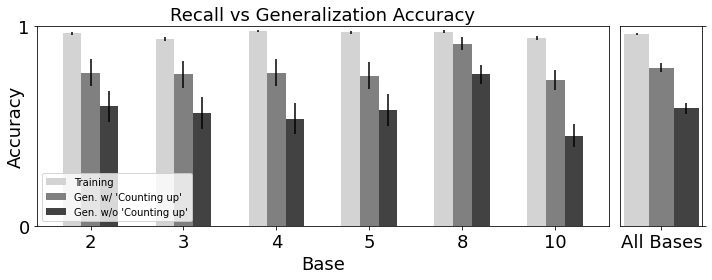

In [58]:



expts = ['1']                                                           # isolate one experiment, or look at it for both
df0 = Q.loc[Q['expt'].isin(expts) & Q['generalized']==True]             # quiz trials
df1 = Gnew.loc[Gnew['expt'].isin(expts) & Gnew['generalized']==True]    # generalization trials

df1['strong_correct'] = df1['strategy_acc'].isin(['add','mul'])         # our exclusive accuracy measure for generalization trials


bw = .2    # bar width - how wide should bars be?

iv = 'base'
dv0 = 'correct'
dv1 = 'correct'
dv2 = 'strong_correct'

dat0 = get_err(df0,iv,dv0)
dat1 = get_err(df1,iv,dv1)
dat2 = get_err(df1,iv,dv2)


f , (a1,a2) = plt.subplots(1,2, figsize=(10,4), sharey=True, gridspec_kw={'width_ratios': [7,1]})


quizcorrect = a1.bar(np.arange(len(dat0[iv]))-2*(bw/2),
        height=dat0[dv0],
        width=bw,
        yerr=dat0['err'],
        fill='lightgrey',color='lightgrey', #edgecolor='k',    # fill='lightgrey',color='lightgrey',# edgecolor='k',
        error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew,'zorder':200},label="Training")

gencorrect = a1.bar(np.arange(len(dat1[iv])),
        height=dat1[dv1],
        width=bw,
        yerr=dat1['err'],
        fill='grey',color='grey', #edgecolor='k',    # fill='grey',color='grey',# edgecolor='k',
        error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew,'zorder':200},label="Gen. w/ 'Counting up'")


genstrong = a1.bar(np.arange(len(dat2[iv]))+2*(bw/2),
        height=dat2[dv2],
        width=bw,
        yerr=dat2['err'],
        fill='#424242',color='#424242', #edgecolor='k',    # fill='grey',color='grey',# edgecolor='k',
        error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew,'zorder':200},label="Gen. w/o 'Counting up'")


a1.set_title("Recall vs Generalization Accuracy")

a1.set_xlabel("Base")
a1.set_xticks([0,1,2,3,4,5])
a1.set_xticklabels(['2','3','4','5','8','10'])

a1.legend(loc="lower left")

a1.set_ylabel("Accuracy")
a1.set_yticks([0,1])    # [0,.2,.8,1]
a1.set_yticklabels(['0','1'])    # ['0','.2','.8','1']
a1.set_ylim((0,1))
# a.yaxis.tick_right()
a1.yaxis.set_label_coords(-.02,.5)

newFontSize([a1],fs=18)

plt.tight_layout()










iv = 'expt'
dv0 = 'correct'
dv1 = 'correct'
dv2 = 'strong_correct'

dat0 = get_err(df0,iv,dv0)
dat1 = get_err(df1,iv,dv1)
dat2 = get_err(df1,iv,dv2)


a2.bar(np.arange(len(dat0[iv]))-2*(bw/2),
        height=dat0[dv0],
        width=bw,
        yerr=dat0['err'],
        fill='lightgrey',color='lightgrey', #edgecolor='k',    # fill='lightgrey',color='lightgrey',# edgecolor='k',
        error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew,'zorder':200})

a2.bar(np.arange(len(dat1[iv])),
        height=dat1[dv1],
        width=bw,
        yerr=dat1['err'],
        fill='grey',color='grey', #edgecolor='k',    # fill='grey',color='grey',# edgecolor='k',
        error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew,'zorder':200})


a2.bar(np.arange(len(dat2[iv]))+2*(bw/2),
        height=dat2[dv2],
        width=bw,
        yerr=dat2['err'],
        fill='#424242',color='#424242', #edgecolor='k',    # fill='grey',color='grey',# edgecolor='k',
        error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew,'zorder':200})


# a2.set_title("Ditto")
# a2.set_xlabel("All")
a2.set_xticks([0])
a2.set_xticklabels(['All Bases'])

# a2.set_ylabel("Accuracy")
a2.set_yticks([0,1])    # [0,.2,.8,1]
a2.set_yticklabels(['0','1'])    # ['0','.2','.8','1']
a2.set_ylim((0,1))
a2.yaxis.tick_right()
a2.yaxis.set_label_coords(-.02,.5)

newFontSize([a2],fs=18)

plt.tight_layout()


f.savefig('../results/plots/fig2.pdf', bbox_inches="tight")  


## <a name="fig3"></a> 7.2.  Figure 3 ([top](#top))

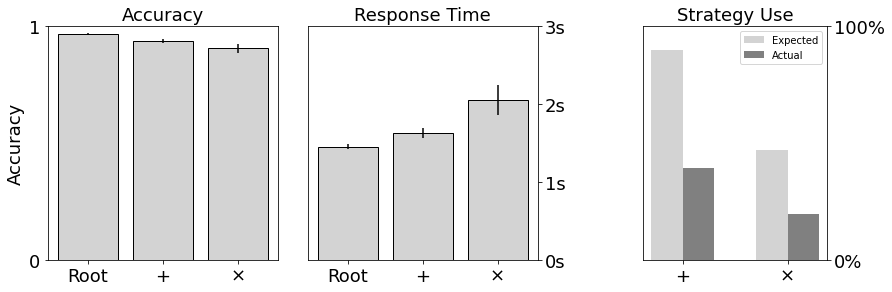

In [60]:
f , (a1,a2,aBlank,a3) = plt.subplots(1,4,figsize=(12,4), gridspec_kw={'width_ratios': [5,5,1,4]})

aBlank.axis("off")

cond_clrs =['black','blue','red']

# load up the data to plot
colour_dict = {'prim':'k','add':'#820303','mult':'#030782'}
colour_dict = {'prim':'k','add':'k','mult':'k'}


plot1s = []
plot2s = []

RTymax = 0

for i,rule in enumerate(['prim','add','mult']):    
    dat0 = get_err(Q1, rule, 'correct')
    dat1 = get_err(Q1, rule, 'RT')
    
    plot1 = a1.bar(x=i,
                   height=dat0.at[1,'correct'],
                   yerr=dat0.at[1,'err'],
                   color="lightgrey", alpha=1, edgecolor=colour_dict[rule])
    
    plot2 = a2.bar(x=i,
                   height=dat1.at[1,'RT'],
                   yerr=dat1.at[1,'err'],
                   color="lightgrey", alpha=1, edgecolor=colour_dict[rule])

    # take whichever is higher: the current max or the highest value here
    RTymax = max(RTymax,dat1.at[1,'RT'] + dat1.at[1,'err'])
    
    plot1s.append(plot1)
    plot2s.append(plot2)



# Now figure layout etc
a1.set_title("Accuracy")
a1.set_ylabel("Accuracy")
a1.set_ylim(0,1)
a1.set_yticks([0,1])
a1.set_yticklabels(["0","1"])
a1.set_xticks([0,1,2])
a1.set_xticklabels(['Root','+','×'])

a2.set_title("Response Time")
a2.set_ylabel("",rotation=270)
a2.yaxis.tick_right()
a2.yaxis.set_label_position("right")
a2.set_ylim(0,np.ceil(RTymax))
a2.set_yticks(np.arange(np.ceil(RTymax)+1))
a2.set_yticklabels([str(int(x))+'s' for x in np.arange(np.ceil(RTymax)+1)])
a2.set_xticks([0,1,2])
a2.set_xticklabels(['Root','+','×'])


















bw = .3    # bar width - how wide should bars be?

dv =  'strategy_acc'

# How will we map strategies to display colours?
strat_colours = {"add":     "#820303", "add_sf":  "#820303",
                 "mul":     "#030782", "mul_sf":  "#030782",
                 "unit":    "k",       "exp":     "k"}

# expected prop additive
prop_expd_add = ((5/5)*31 + (5/5)*30 + (4/5)*32 + (4/5)*30 + (9/10)*30 + (9/10)*29) / (31+30+32+30+30+29)

# actual prop additive (generous)
prop_actl_add = df1[dv].value_counts()['add'] / df1[dv].value_counts().sum()



a3.bar(0-bw/2,
        height= prop_expd_add,
        width=bw,
        fill='lightgrey', color='lightgrey',alpha=1, edgecolor=None,
        error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew})

a3.bar(0+bw/2,
        height= prop_actl_add,
        width=bw,
        fill='grey', color='grey',alpha=1, edgecolor=None,
        error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew})



# expected prop multiplicative
prop_expd_mul = ((0/5)*31 + (1/5)*30 + (5/5)*32 + (5/5)*30 + (5/10)*30 + (1/10)*29) / (31+30+32+30+30+29)

# actual prop multiplicative (generous)
prop_actl_mul = df1[dv].value_counts()['mul'] / df1[dv].value_counts().sum()


    
expected = a3.bar(1-bw/2,
        height= prop_expd_mul,
        width=bw,
        fill='lightgrey', color='lightgrey',alpha=1, edgecolor=None,
        error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew},label="Expected")

actual = a3.bar(1+bw/2,
        height= prop_actl_mul,
        width=bw,
        fill='grey', color='grey',alpha=1, edgecolor=None,
        error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':ew},label="Actual")

a3.legend()

a3.set_title("Strategy Use")
a3.set_ylabel("")
a3.set_yticks([0,1])
a3.set_yticklabels(['0%','100%'])
a3.set_ylim((0,1))
a3.yaxis.tick_right()
# a3.yaxis.set_label_coords(-.02,.5)
a3.yaxis.set_label_position("right")



# a3.set_xlabel("Base")
a3.set_xticks([0,1])
a3.set_xticklabels(['+','×'])

plt.tight_layout()
newFontSize([a1,a2,a3],fs=18)

f.savefig('../results/plots/fig3.pdf', bbox_inches="tight")  

## <a name="fig4"></a> 7.3.  Figure 4 ([top](#top))

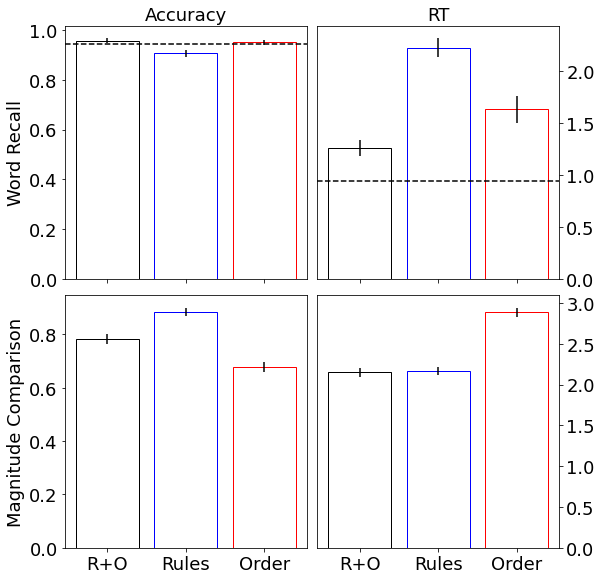

In [44]:
f , ((a1,a2),(a3,a4)) = plt.subplots(2,2,figsize=(8,8), sharex=True)

cond_clrs =['black','blue','red']

dat0 = get_err(Q2,'cond','correct')
dat1 = get_err(Q2,'cond','RT')

a1plot = a1.bar(np.arange(3),
       height=dat0['correct'],
       yerr=dat0['err'],color="white",alpha=1)

a2plot = a2.bar(np.arange(3),
       height=dat1['RT'],
       yerr=dat1['err'],color="white",alpha=1)

datQ1 = get_err(Q1,'base','correct')
a1.axhline(datQ1.at[3,'correct'], c='k', linestyle='--')
a2.axhline(datQ1.at[3,'correct'], c='k', linestyle='--')





dat0 = get_err(M,'cond','correct')
dat1 = get_err(M,'cond','RT')

a3plot = a3.bar(np.arange(3),
       height=dat0['correct'],
       yerr=dat0['err'],color="white",alpha=1)

a4plot = a4.bar(np.arange(3),
       height=dat1['RT'],
       yerr=dat1['err'],color="white",alpha=1)


for i in np.arange(3):
    a1plot[i].set_edgecolor(cond_clrs[i])
    a2plot[i].set_edgecolor(cond_clrs[i])
    a3plot[i].set_edgecolor(cond_clrs[i])
    a4plot[i].set_edgecolor(cond_clrs[i])


a1.set_title("Accuracy")
a1.set_ylabel("Word Recall")
a1.set_xticks([])
a1.set_xticklabels([])

a2.set_title("RT")
a2.set_ylabel("")
a2.yaxis.tick_right()
a2.yaxis.set_label_position("right")
a2.set_xticks([])
a2.set_xticklabels([])

a3.set_title("")
a3.set_ylabel("Magnitude Comparison")
a3.set_xticks([0,1,2])
a3.set_xticklabels(["R+O","Rules","Order"])

a4.set_title("")
a4.set_ylabel("")
a4.yaxis.tick_right()
a4.yaxis.set_label_position("right")
a4.set_xticks([0,1,2])
a4.set_xticklabels(["R+O","Rules","Order"])


plt.tight_layout()
newFontSize([a1,a2,a3,a4],fs=18)

# f.savefig('../results/plots/fig3/frame_{}.png'.format(frame), bbox_inches="tight")  

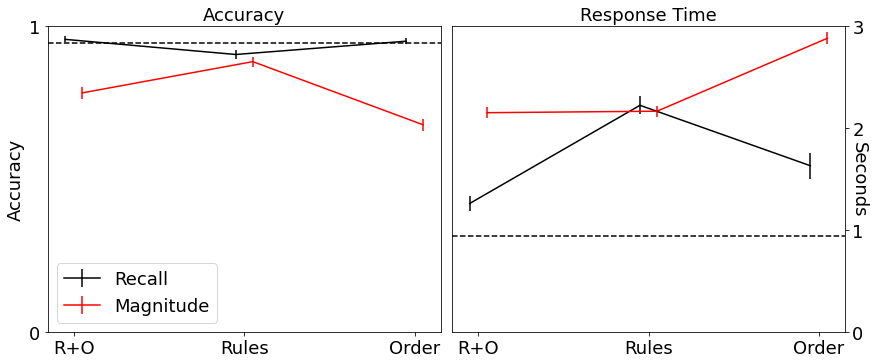

In [65]:
f , (a1,a2) = plt.subplots(1,2,figsize=(12,5))

cond_clrs =['black','blue','red']

# load up the data to plot
dat0 = get_err(Q2,'cond','correct')
dat1 = get_err(Q2,'cond','RT')
dat2 = get_err(M,'cond','correct')
dat3 = get_err(M,'cond','RT')
datQ1 = get_err(Q1,'base','correct')


a1plot = a1.errorbar(np.arange(3) - .05,
                     y=dat0['correct'],
                     yerr=dat0['err'],
                     c='k',
                     label='Recall')

a2plot = a2.errorbar(np.arange(3) - .05,
                     y=dat1['RT'],
                     yerr=dat1['err'],
                     c='k')

a3plot = a1.errorbar(np.arange(3) + .05,
                     y=dat2['correct'],
                     yerr=dat2['err'],
                     c='r',
                     label='Magnitude')

a4plot = a2.errorbar(np.arange(3) + .05,
                     y=dat3['RT'],
                     yerr=dat3['err'],
                     c='r')


a1.axhline(datQ1.at[3,'correct'], c='k', linestyle='--')
a2.axhline(datQ1.at[3,'correct'], c='k', linestyle='--')


# Now figure layout etc
a1.set_title("Accuracy")
a1.set_ylabel("Accuracy")
a1.set_ylim(0,1)
a1.set_yticks([0,1])
a1.set_yticklabels(["0","1"])
a1.set_xticks([0,1,2])
a1.set_xticklabels(['R+O','Rules','Order'])

a2.set_title("Response Time")
a2.set_ylabel("Seconds",rotation=270)
a2.set_ylim(0,np.ceil(max(np.max(dat1['RT']+dat1['err']),np.max(dat3['RT']+dat3['err']))))
a2.yaxis.tick_right()
a2.yaxis.set_label_position("right")
a2.set_yticks([0,1,2,3])
a2.set_xticks([0,1,2])
a2.set_xticklabels(['R+O','Rules','Order'])


a1.legend(handles=[a1plot, a3plot], fontsize=18)

plt.tight_layout()
newFontSize([a1,a2,a3,a4],fs=18)

f.savefig('../results/plots/fig4.pdf', bbox_inches="tight")  

## <a name="simpsons"></a> 8.  Simpsons Diversity Measure ([top](#top))

In [46]:
gRULES_ORDER = G[(G['expt']=='2')&(G['syntax']==True)&(G['count']==True)].loc[G['num']>10]
gRULES_ONLY = G[(G['expt']=='2')&(G['syntax']==True)&(G['count']==False)].loc[G['num']>10]


classification = 'num'

# get the estimate for Simpson's diversity index within each condition

def getSimpsons(g,classification):
    simpsons = g.groupby([classification,'gloss'])[['gloss']].count(
    ).groupby(classification)[['gloss']].apply(
        lambda x: 1 - (sum([y*(y-1) for y in list(x['gloss'])]) / 
        (x['gloss'].sum()*(x['gloss'].sum() - 1))))
    simpsons.name = "Simpson's Diversity Index"

    # now bootstrap some uncertainty around that measure
    subset_sims = np.zeros([len(g[classification].unique()),0])

    for i in range(500):
        np.random.seed(i)
        subset_games = np.random.choice(g.GID.unique(), len(g.GID.unique()), replace=True)
        subset_g = g[g['GID'].apply(lambda x: x in subset_games)]
        cur_sim = np.array(subset_g.groupby([classification,'gloss'])[['gloss']].count(
        ).groupby(classification)[['gloss']].apply(
            lambda x: 1 - (sum([y*(y-1) for y in list(x['gloss'])]) / 
                           (x['gloss'].sum()*(x['gloss'].sum() - 1)))))

        subset_sims = np.append(subset_sims,np.array([cur_sim]).T,axis=1)

    upperCI = np.quantile(subset_sims, .975, axis=1, keepdims = True, interpolation = 'nearest') # can't use 'method' because my python is outdated
    lowerCI = np.quantile(subset_sims, .025, axis=1, keepdims = True, interpolation = 'nearest') # can't use 'method' because my python is outdated
    upperCI = pd.DataFrame(np.squeeze(upperCI), columns=['upper']).reset_index().rename(columns={'index':classification})
    lowerCI = pd.DataFrame(np.squeeze(lowerCI), columns=['lower']).reset_index().rename(columns={'index':classification})
    
    measured_avg = simpsons.mean()
    
    return {'measured':pd.DataFrame(simpsons).reset_index(), 'upperCI':upperCI, 'lowerCI':lowerCI,
            'measured_avg':measured_avg, 'err_avg':  upperCI['upper'].mean() - measured_avg}


simpsons_dict_RULES_ORDER = getSimpsons(gRULES_ORDER,'num')
simpsons_dict_RULES_ONLY = getSimpsons(gRULES_ONLY,'num')

print("Index: {}, CI: [{} , {}]".format(np.round(simpsons_dict_RULES_ORDER['measured_avg'],4),
                                        np.round(simpsons_dict_RULES_ORDER['measured_avg']-simpsons_dict_RULES_ORDER['err_avg'],4),
                                        np.round(simpsons_dict_RULES_ORDER['measured_avg']+simpsons_dict_RULES_ORDER['err_avg'],4)))

      
print("Index: {}, CI: [{} , {}]".format(np.round(simpsons_dict_RULES_ONLY['measured_avg'],4),
                                        np.round(simpsons_dict_RULES_ONLY['measured_avg']-simpsons_dict_RULES_ONLY['err_avg'],4),
                                        np.round(simpsons_dict_RULES_ONLY['measured_avg']+simpsons_dict_RULES_ONLY['err_avg'],4)))


Index: 0.803, CI: [0.7271 , 0.8789]
Index: 0.7692, CI: [0.6761 , 0.8623]
